## create TFRecord dataset

In [5]:
import os
import cv2 
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import hashlib

%matplotlib inline

In [4]:
print("open CV version    : " + cv2.__version__)
print("tensorflow version : " + tf.__version__)
print("tensorflow with gup: " + str(tf.test.is_gpu_available()))

open CV version    : 3.4.2
tensorflow version : 1.9.0
tensorflow with gup: False


### 從網路上下載素材

In [332]:
# 下載素材，並以 hash md5 作為唯一值，來避免重複
# 不重複的圖則存進本地端

chart_list = list()
url_list = material_300_250[4].values.tolist()

for url in url_list:
    im_req = requests.get(url) # requests image 的 byte 格式
    im_hash = hashlib.md5(im_req.content).hexdigest()
    # 只抓圖片檔，先不處理 gif 檔
    if (im_hash not in chart_list) and (url.split('.')[-1] != 'gif'): 
        im_str = np.frombuffer(im_req.content, np.uint8) # 將圖片 byte 型態解析為 array
        im_arr = cv2.imdecode(im_str, cv2.IMREAD_COLOR)
        if im_arr is not None:
            cv2.imwrite("material/" + im_hash + ".jpg", im_arr) # 將圖片存到 local 端
        else:
            im_hash = None
    chart_list.append(im_hash)
print("done!")

done!


In [8]:
print(labels)

[2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0]


### 將資料存成 TFRecord

In [408]:
# 創建 TFRecord 所需的 function
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_image(path, resize=False, size=None, normalization=False):
    ''' 讀取圖片檔案為 np.array 格式
    Args:
      path: (str), 檔案路徑。
      resize: (boolean), 縮放圖片大小。
      size: (tuple), 如果要縮方圖片，設定欲縮放的大小。
      normalization: (boolean), 將圖檔陣列數值縮放為0~1之間的normalization
    
    return:
      im_arr: (np.array), 圖檔的陣列
    '''
    im_arr = cv2.imread(path)[:,:,(2, 1, 0)]
    if resize:
        im_arr = cv2.resize(im_arr, size, interpolation=cv2.INTER_CUBIC)
    if normalization:
        im_arr = im_arr / np.float32(255)
    return im_arr

In [9]:
for path, dir, files in os.walk("material/"):
    path_list = [file for file in files if file]
output_path = 'material/train_250_300.tfrecords'

In [11]:
path_list[0:3]

['9ed18f313f4a3b87b763e271510443e5.jpg',
 'bb8d712002d54ea017989b22d8e1c730.jpg',
 '44cac35abecebccc4a449a62f4327d5f.jpg']

In [424]:
# 創建 TRFecord，寫入TFRecord 檔案的標準做法是：
# 1. 把所有資料轉換成「tf.train.Feature」格式。
# 2. 把所有的「tf.train.Feature」包裝成「tf.train.Features」格式。
# 3. 把所有的「tf.train.Features」組合成「tf.train.Example」格式。
# 4. 先將「tf.train.Example」轉為 byte 格式，並利用「tf.python_io.TFRecordWriter」寫入成 TFRecord 檔案。
with tf.python_io.TFRecordWriter(output_path) as record_writer:
    for i, path in enumerate(path_list):
        image = get_image(path="material/" + path, resize=True, size=(250, 300), normalization=True)
        label = labels[i]
        ftrs = tf.train.Features(
            feature = {'image': _bytes_feature(image.tobytes()),
                       'label': _int64_feature(label),}
        )
        example = tf.train.Example(features=ftrs)
        record_writer.write(example.SerializeToString())
print("transform done!")

transform done!


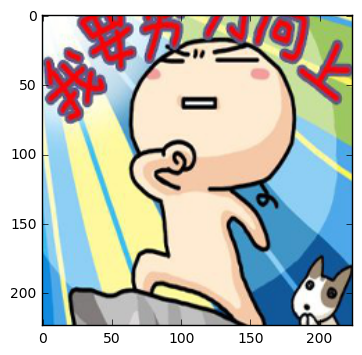

In [426]:
plt.imshow(image)

### 使用 Dataset 讀取 TFRecord

In [14]:
# 使用 tf.data.TFRecordDataset 讀取 TFRecord 檔案
output_path = ['material/train_250_300.tfrecords']
dataset = tf.data.TFRecordDataset(output_path)


# parser dataset，因為是 TFRecord，所以要定義解析函數
# 而且是從反向開始解析， Example -> Features -> Feature
def parser(record):
    keys_to_features = {
        'image': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
    }
    parsed = tf.parse_single_example(record, keys_to_features)
    #image = tf.decode_raw(parsed['image'], tf.float32)
    image = tf.decode_raw(parsed['image'], tf.uint8)
    image = tf.reshape(image, [250, 300, 3])
    label = tf.cast(parsed['label'], tf.int32)
    return image, label

dataset = dataset.map(parser) # 參數為一個函數
dataset = dataset.shuffle(500)  # 洗亂數據，參數要大於數據量
dataset = dataset.repeat(1)   # num_epochs 代表要遍歷幾次數據
dataset = dataset.batch(4)   # 批次讀取量的大小

#3 use iterator get value 定义迭代器，才能获得起张量
iterator = dataset.make_one_shot_iterator()
image, label = iterator.get_next()

def show_plot(image_data):
    plt.figure(figsize=(18, 5))
    plt.subplot(1,4,1)
    plt.imshow(image_data[0])

    plt.subplot(1,4,2)
    plt.imshow(image_data[1])

    plt.subplot(1,4,3)
    plt.imshow(image_data[2])

    plt.subplot(1,4,4)
    plt.imshow(image_data[3])
    plt.show()

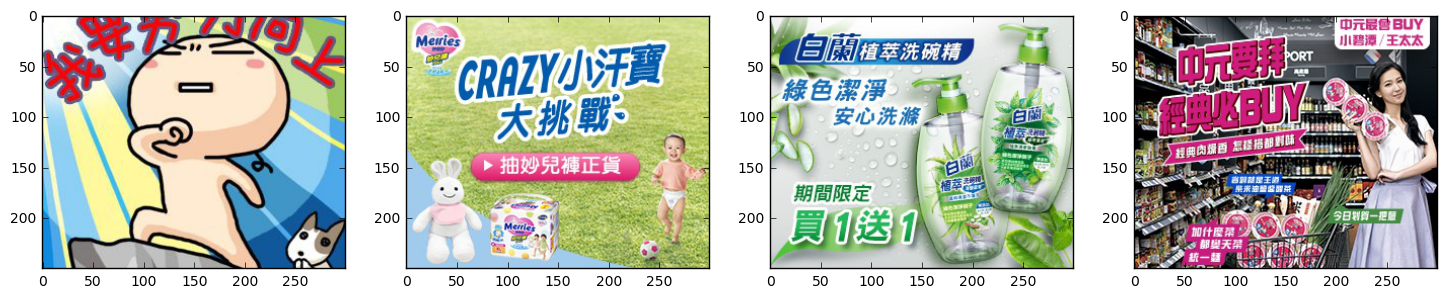

[0 2 0 2]


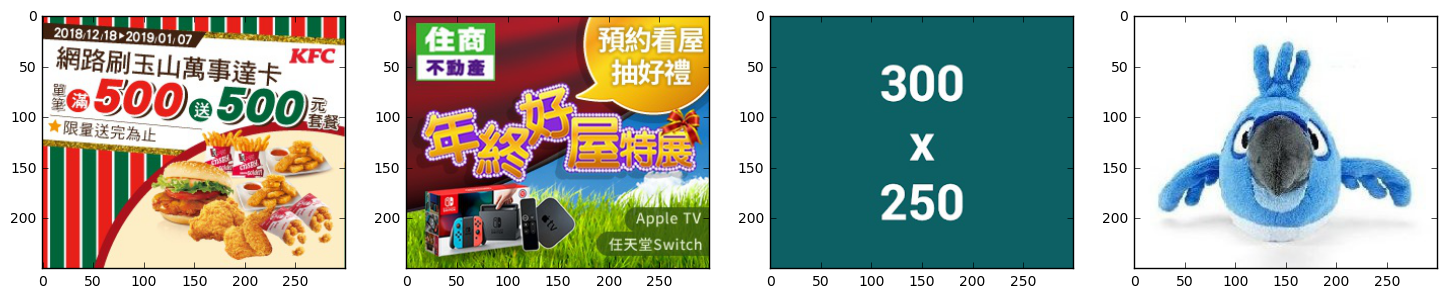

[0 0 0 0]


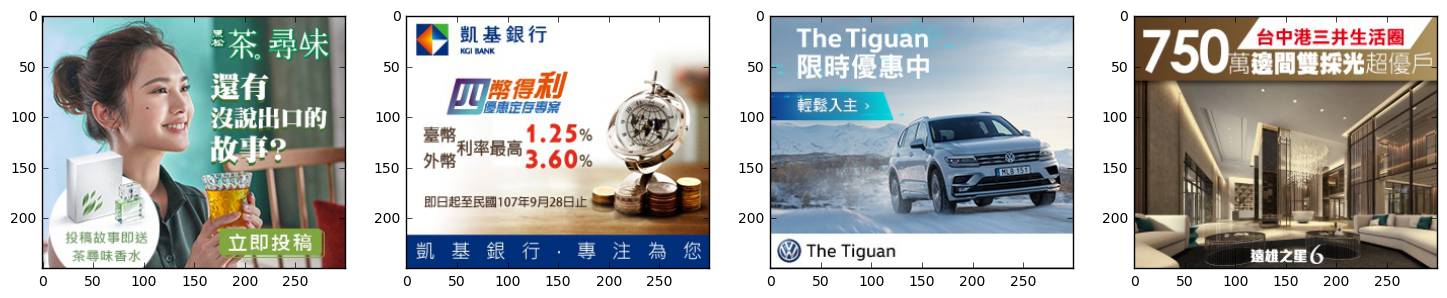

[2 0 1 0]


In [15]:
with tf.Session() as sess:
    for i in range(0, 3):
        image_data, label_data = sess.run([image, label])
        show_plot(image_data)
        print(label_data)
# label 0: 其他
# label 1: 汽車 
# label 2: 人像